# Navigation par corrélation de terrain

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy import random
from numpy.random import multinomial
import numpy.linalg
import math
from scipy import interpolate

dict_keys(['__header__', '__version__', '__globals__', 'ans', 'dt_resol', 'h_MNT', 'i', 'j', 'lat_reel', 'rayon', 'resol_ang', 'x_MNT', 'y_MNT'])
(1, 799)


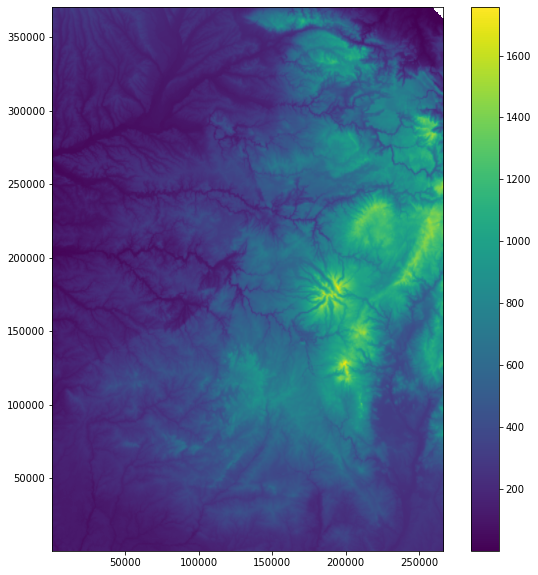

In [71]:
data = loadmat('carte_centreMetres.mat');
print(data.keys())
h_mnt = data["h_MNT"]
h_mnt = np.flip(h_mnt,axis = 0)
x_mnt = data["x_MNT"]
y_mnt = data["y_MNT"]
print(np.shape(x_mnt))
plt.figure(figsize = (10,10))
plt.imshow(h_mnt,extent = [x_mnt[0,0],x_mnt[0,-1],y_mnt[0,0],y_mnt[0,-1]])
plt.colorbar()



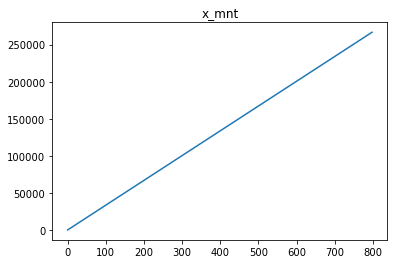

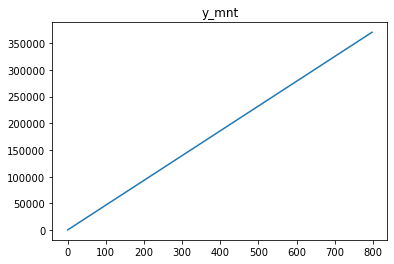

In [3]:
plt.plot(x_mnt[0])
plt.title("x_mnt")
plt.show()
plt.plot(y_mnt[0])
plt.title("y_mnt")
plt.show()

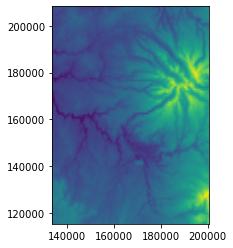

In [11]:

# print(x_mnt[0,400])
# print(x_mnt[0,650])

y_mnt_1 = np.flip(y_mnt[0])

indice_y_min=350
indice_y_max=550
indice_x_min=400
indice_x_max=600
exten = [x_mnt[0,indice_x_min],x_mnt[0,indice_x_max],y_mnt_1[indice_y_max],y_mnt_1[indice_y_min]]
h_red = h_mnt[indice_y_min:indice_y_max,indice_x_min:indice_x_max]
plt.imshow(h_red, extent = exten)
plt.show()

In [5]:
def redistribution(X,w):
    w_normalise = w/np.sum(w)
    shape = np.shape(X)
    n = shape[0]
    multinom = multinomial(n,w_normalise)
    X_redistribue = []
    for i in range(n):
        for j in range(multinom[i]):
            X_redistribue.append(X[i]) 
    X_redistribue = np.array(X_redistribue)
    return(X_redistribue)

In [6]:
def reechantillonage(X_redistribue,h):
    shape = np.shape(X_redistribue)
    n = shape[0]
    p = shape[1]
    X_reechant = np.zeros((n,p))
    cov = np.cov(X_redistribue.T)
    gamma = np.linalg.cholesky(cov)
    for i in range(n):
        X_reechant[i]= X_redistribue[i] + h*np.dot(gamma,np.random.normal(0,1,p))
    return(X_reechant)

### Constantes

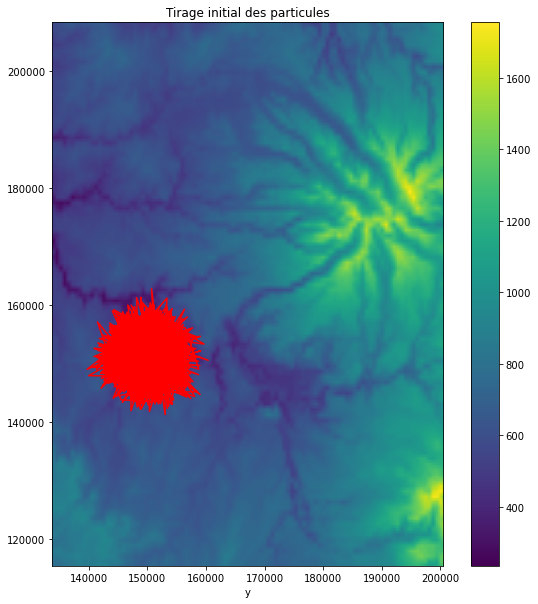

In [68]:
# constantes
dt = 1
phi = np.identity(6)
for i in range(3):
    phi[i,i+3]=dt
incertitude_x = 3000
incertitude_y = 3000
incertitude_z = 500
incertitude_vitesse = 5
vitavion = 300*1000/3600
capavion = 45*math.pi/180
X0_vrai =np.array([150*1000,150*1000,8000,vitavion*math.cos(capavion),vitavion*math.sin(capavion),0])
sigma_bruit =30
array_incertitude = np.array([incertitude_x,incertitude_y,incertitude_z,incertitude_vitesse,incertitude_vitesse,incertitude_vitesse])
P0 = np.diag(array_incertitude)
racine_P0 = np.sqrt(P0)
pseudoX0 = X0_vrai+2*np.array([np.random.uniform(0,incertitude) for incertitude in array_incertitude])- array_incertitude
N_part = 5000
particules_0 = np.array([pseudoX0+ np.dot(P0,np.random.normal(0,1,6)) for i in range(N_part)])
T=720
plt.figure(figsize = (10,10))
plt.imshow(h_red,extent = exten)
plt.title("Tirage initial des particules")
plt.xlabel("x")
plt.xlabel("y")
plt.plot(particules_0[:,0],particules_0[:,1],'r')
plt.colorbar()



In [15]:
def dynamique(X0,phi,T):
    n,= np.shape(X0)
    X = np.zeros((T,n))
    X[0]=X0
    for i in range(1,T):
        X[i]=np.dot(phi,X[i-1])
    return(X)    

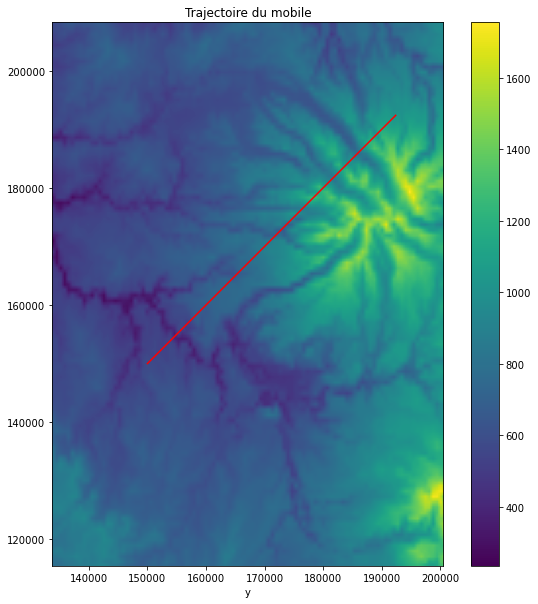

In [67]:
trajectoire = dynamique(X0_vrai,phi,T)
plt.figure(figsize = (10,10))
plt.imshow(h_red,extent = exten)
plt.title("Trajectoire du mobile")
plt.xlabel("x")
plt.xlabel("y")
plt.plot(trajectoire[:,0],trajectoire[:,1],'r')
plt.colorbar()

In [63]:
def mesure_bruitee(trajectoire,sigma_bruit):
    n,p = np.shape(trajectoire)
    mes = np.zeros(n)
    for i in range(n):
        mes[i]= mesure(trajectoire[i,0],trajectoire[i,1],trajectoire[i,2])+np.random.normal(0,sigma_bruit)
    return(mes)

def indice(x,y):
    delta_x =x_mnt[0,-1]-x_mnt[0,0]
    delta_y = y_mnt[0,-1]-y_mnt[0,0]
    indice_x = (x-x_mnt[0,0])*799/(delta_x)
    indice_y = (y-y_mnt[0,0])*799/(delta_y)
    return(max(0,min(int(indice_x),798)),798-max(0,min(int(indice_y),798)))

def mesure(x,y,z):
    indice_x,indice_y = indice(x,y)
    return(z-h_mnt[indice_x,indice_y])



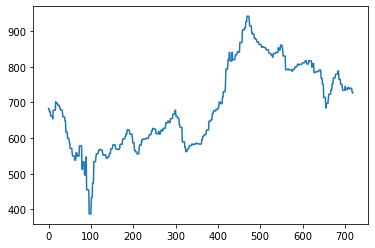

In [66]:
array_indices = np.array([indice(x[0],x[1]) for x in trajectoire])
plt.plot(h_mnt[array_indices[:,0],array_indices[:,1]])

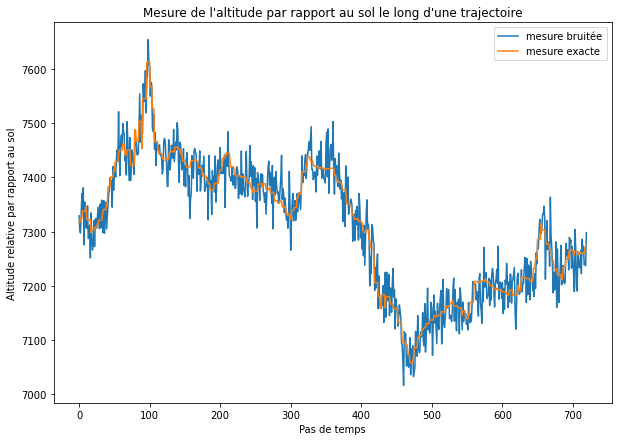

In [72]:
mesure_bruitees_traj = mesure_bruitee(trajectoire,sigma_bruit)
mesure_exactes = np.array([mesure(etat[0],etat[1],etat[2]) for etat in trajectoire])
plt.figure(figsize=(10,7))
plt.plot(mesure_bruitees_traj)
plt.plot(mesure_exactes)
plt.title("Mesure de l'altitude par rapport au sol le long d'une trajectoire")
plt.xlabel("Pas de temps")
plt.ylabel('Altitude relative par rapport au sol')
plt.legend(['mesure bruitée','mesure exacte'])

### iterpolation

In [329]:
absc = np.arange(0,799,1)
ord = np.arange(0,799,1) 
modele_interpole = interpolate.interp2d(absc,ord,h_mnt,kind = 'cubic')
modele_interpole(500,500)

array([nan])

### filtrage particulaire

In [73]:
def vraissemblance(etat,observation):
    return(noyeau_gaussien(observation-mesure(etat[0],etat[1],etat[2])))

def noyeau_gaussien(x):
    return(np.exp((-x**2)/(2*(sigma_bruit**2)))/np.sqrt(2*math.pi*sigma_bruit))

def filtrage_particulaire(particules_0,mesure_traj,N_th,phi,T,h):
    n,p = np.shape(trajectoire)
    N_part,p_part = np.shape(particules_0)
    particules = np.zeros((T,N_part,p))
    particules[0]= particules_0
    weights = np.ones(N_part)/N_part
    particules_temp = np.zeros((N_part,p))
    for i in range(1,T):
        #evolution/prediction
        particules_temp = np.zeros((N_part,p))
        for j in range(N_part):
            particules_temp[j] = np.dot(phi,particules[i-1,j])
            #correction
            weights[j]=vraissemblance(particules_temp[j],mesure_traj[i])
        weights = weights/np.sum(weights)
        X_redistribue = redistribution(particules_temp,weights)
        critère = 1/np.sum(weights**2)
        if critère <=N_th:
            X_redistribue = reechantillonage(X_redistribue,h)
        particules[i]=X_redistribue
    return(particules)


In [74]:
h_opt = (4/3)**(1/5)*N_part**(-1/5)
print(h_opt)

0.19283850080052542


In [75]:
particules = filtrage_particulaire(particules_0, mesure_bruitees_traj, 0.6*N_part,phi,T,h=h_opt)

In [82]:
with open('particules.npy','wb') as f : 
    np.save(f,particules)
with open('trajectoire.npy','wb') as f : 
    np.save(f,trajectoire)
# with open('particules.npy','rb') as f:
#     particules = np.load(f)
# with open('trajectoire.npy','rb') as f:
#     trajectoire = np.load(f)

In [79]:
def figure(iteration, particules, trajectoire):    
    plt.figure(figsize = (5,5))
    plt.title("Trajectoire et particules, itération : "+str(iteration))
    plt.imshow(h_mnt[indice_y_min:indice_y_max,indice_x_min:indice_x_max], extent = [x_mnt[0,indice_x_min],x_mnt[0,indice_x_max],y_mnt_1[indice_y_max],y_mnt_1[indice_y_min]])
    plt.plot(particules[iteration,:,0],particules[iteration,:,1],'r')
    plt.colorbar()
    plt.plot(trajectoire[:iteration,0], trajectoire[:iteration,1],'g')
    plt.show()

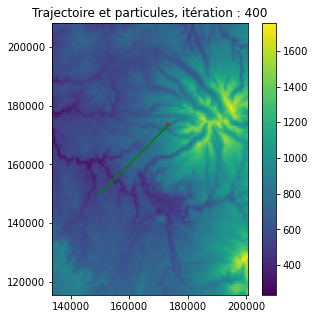

In [83]:
# for i in range (40):
#     figure(i*10, particules, trajectoire)
figure(400, particules, trajectoire)

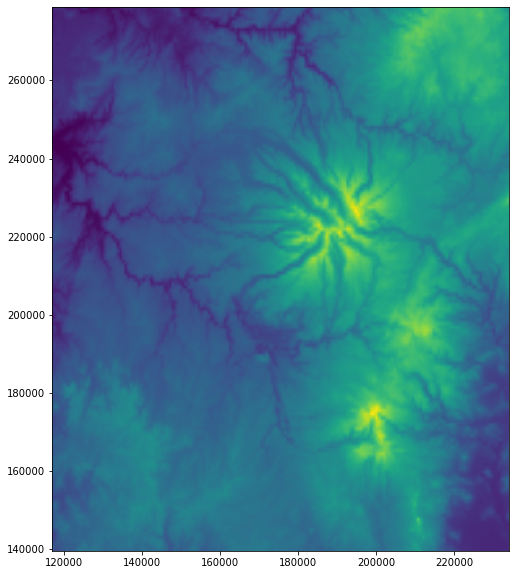

In [112]:
plt.figure(figsize = (10,10))
indice_x_min, indice_x_max = 350,700
indice_y_min, indice_y_max = 300,600
extend = [x_mnt[0,indice_x_min],x_mnt[0,indice_x_max],y_mnt[0,indice_y_min],y_mnt[0,indice_y_max]]

plt.imshow(h_mnt[indice_y_min:indice_y_max,indice_x_min:indice_x_max],extent = extend)